In [1]:
import pandas as pd
import numpy as np

from pyincore import IncoreClient
from pyincore.analyses.socialvulnerability import SocialVulnerability
from pyincore_data.censusutil import CensusUtil
from pyincore import Dataset

In [2]:
client = IncoreClient()

Enter username:  zacbaker
Enter password:  ········


Connection successful to IN-CORE services. pyIncore version detected: 1.14.0


In [3]:
state = "florida"
county = "lee"
year = 2022

In [4]:
# get fips code to use fetch census data
fips = CensusUtil.get_fips_by_state_county(state=state, county=county)
state_code = fips[:2]
county_code = fips[2:]
fips

'12071'

In [5]:
def demographic_factors(state_number, county_number, year, geo_type="tract:*"):

    api_json_1, df_1, ds_1 = CensusUtil.get_census_data(state=state_code, county=county_code, year=year,
                                                              data_source="acs/acs5",
                                                              columns="GEO_ID,B03002_001E,B03002_003E",
                                                              geo_type=geo_type)
    df_1["factor_white_nonHispanic"] = df_1[["B03002_001E","B03002_003E"]].astype(int).apply(lambda row: row["B03002_003E"]/row["B03002_001E"] if row["B03002_001E"] != 0 else 999, axis = 1)

    api_json_2, df_2, ds_2 = CensusUtil.get_census_data(state=state_code, county=county_code, year=year,
                                                  data_source="acs/acs5",
                                                  columns="B25003_001E,B25003_002E",
                                                  geo_type=geo_type)
    df_2["factor_owner_occupied"] = df_2.astype(int).apply(lambda row: row["B25003_002E"]/row["B25003_001E"] if row["B25003_001E"] != 0 else 999, axis = 1)
    
    api_json_3, df_3, ds_3 = CensusUtil.get_census_data(state=state_code, 
                                         county=county_code, 
                                         year=year,
                                         data_source="acs/acs5",
                                         columns="B17021_001E,B17021_002E",
                                         geo_type=geo_type)
    df_3["factor_earning_higher_than_national_poverty_rate"] = df_3.astype(int).apply(lambda row: 1-row["B17021_002E"]/row["B17021_001E"] if row["B17021_001E"] != 0 else 999, axis = 1)
    
    api_json_4, df_4, ds_4 = CensusUtil.get_census_data(state=state_code, 
                                         county=county_code, 
                                         year=year,
                                         data_source="acs/acs5", 
                                         columns="B15003_001E,B15003_017E,B15003_018E,B15003_019E,B15003_020E,B15003_021E,B15003_022E,B15003_023E,B15003_024E,B15003_025E",
                                         geo_type=geo_type)
    df_4["factor_over_25_with_high_school_diploma_or_higher"] = df_4.astype(int).apply(lambda row: (row["B15003_017E"] 
                                                                                                    + row["B15003_018E"] 
                                                                                                    + row["B15003_019E"] 
                                                                                                    + row["B15003_020E"] 
                                                                                                    + row["B15003_021E"] 
                                                                                                    + row["B15003_022E"] 
                                                                                                    + row["B15003_023E"] 
                                                                                                    + row["B15003_024E"] 
                                                                                                    + row["B15003_025E"])/row["B15003_001E"] if row["B15003_001E"] != 0 else 999, axis = 1)

    if geo_type == 'tract:*':
        api_json_5, df_5, ds_5 = CensusUtil.get_census_data(state=state_code, 
                                             county=county_code, 
                                             year=year,
                                             data_source="acs/acs5",
                                             columns="B18101_001E,B18101_011E,B18101_014E,B18101_030E,B18101_033E",
                                             geo_type=geo_type)
        df_5["factor_without_disability_age_18_to_65"] = df_5.astype(int).apply(lambda row: (row["B18101_011E"] + row["B18101_014E"] + row["B18101_030E"] + row["B18101_033E"])/row["B18101_001E"] if row["B18101_001E"] != 0 else 999, axis = 1)
    
    elif geo_type == 'block%20group:*':
        api_json_5, df_5, ds_5 = CensusUtil.get_census_data(state=state_code, 
                                             county=county_code, 
                                             year=year,
                                             data_source="acs/acs5",
                                             columns="B01003_001E,C21007_006E,C21007_009E,C21007_013E,C21007_016E",
                                             geo_type=geo_type)

        df_5['factor_without_disability_age_18_to_65'] = df_5.astype(int).apply(lambda row: (row['C21007_006E']+
                                                                                 row['C21007_006E']+
                                                                                 row['C21007_009E']+
                                                                                 row['C21007_013E'])
                                                                                /row['C21007_016E'] if row["C21007_016E"] != 0 else 999, axis = 1)

    df_t = pd.concat([df_1[["GEO_ID","factor_white_nonHispanic"]],
                      df_2["factor_owner_occupied"],
                      df_3["factor_earning_higher_than_national_poverty_rate"], 
                      df_4["factor_over_25_with_high_school_diploma_or_higher"],
                      df_5["factor_without_disability_age_18_to_65"]], 
                     axis=1, join='inner')
    
    # extract FIPS from geo id
    df_t["FIPS"] = df_t.apply(lambda row: row["GEO_ID"].split("US")[1], axis = 1)
        
    return df_t

In [6]:
def national_ave_values (year, data_source="acs/acs5"):
    api_json_1, nav1, ds_1 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B03002_001E,B03002_003E",geo_type=None)
    nav1 = nav1.astype(int)
    nav1_avg ={"feature": "NAV-1: White, nonHispanic", 
                "average": nav1['B03002_003E'].sum()/ nav1['B03002_001E'].sum()}

    api_json_2, nav2, ds_2 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B25003_001E,B25003_002E",geo_type=None)
    nav2 = nav2.astype(int)
    nav2_avg = {"feature": "NAV-2: Home Owners", 
                "average": nav2['B25003_002E'].sum()/nav2['B25003_001E'].sum()}

    api_json_3, nav3, ds_3 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B17021_001E,B17021_002E",geo_type=None)
    nav3 = nav3.astype(int)
    nav3_avg = {"feature": "NAV-3: earning higher than national poverty rate", 
                "average": 1-nav3['B17021_002E'].sum()/nav3['B17021_001E'].sum()}

    api_json_4, nav4, ds_4 = CensusUtil.get_census_data(state="*", 
                                         county=None, 
                                         year=year,
                                         data_source="acs/acs5",
                                         columns="B15003_001E,B15003_017E,B15003_018E,B15003_019E,B15003_020E,B15003_021E,B15003_022E,B15003_023E,B15003_024E,B15003_025E",
                                         geo_type=None)
    nav4 = nav4.astype(int)
    nav4['temp'] = nav4.apply(lambda row: row['B15003_017E']+row['B15003_018E']+row['B15003_019E']+
                              row['B15003_020E']+row['B15003_021E']+row['B15003_022E']+row['B15003_023E']+
                              row['B15003_024E']+row['B15003_025E'], axis = 1)
    nav4_avg = {"feature": 'NAV-4: over 25 with high school diploma or higher', 
                "average": nav4['temp'].sum()/nav4['B15003_001E'].sum()}

    api_json_5, nav5, ds_5 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B18101_001E,B18101_011E,B18101_014E,B18101_030E,B18101_033E",
                                         geo_type=None)
    nav5 = nav5.astype(int)
    nav5['temp'] = nav5.apply(lambda row: row['B18101_011E']+row['B18101_014E']+row['B18101_030E']+row['B18101_033E'], axis = 1)
    nav5_avg = {"feature": 'NAV-5: without disability age 18 to 65', 
                "average": nav5["temp"].sum()/nav5["B18101_001E"].sum()}
    
    navs = [nav1_avg, nav2_avg, nav3_avg, nav4_avg, nav5_avg]
    
    return navs

In [7]:
navs = national_ave_values(year=2022)
national_vulnerability_feature_averages = Dataset.from_csv_data(navs, name="national_vulnerability_feature_averages.csv",
                                                                 data_type="incore:socialVulnerabilityFeatureAverages")

csv saved as api_20240523-085403.csv
csv saved as api_20240523-085404.csv
csv saved as api_20240523-085405.csv
csv saved as api_20240523-085407.csv
csv saved as api_20240523-085409.csv


In [69]:
geo_type = "tract:*"
social_vunlnerability_dem_factors_df = demographic_factors(state_code, county_code, year=2022, geo_type=geo_type)
social_vunlnerability_dem_factors = Dataset.from_dataframe(social_vunlnerability_dem_factors_df, 
                                                           name="social_vunlnerability_dem_factors",
                                                           data_type="incore:socialVulnerabilityDemFactors")

Exception: Failed to download the data from Census API. Please check your parameters.

In [9]:
# Configure pyincore access and the analysis with the information above

client = IncoreClient()
social_vulnerability = SocialVulnerability(client)

social_vulnerability.set_parameter("result_name", "social_vulnerabilty")
social_vulnerability.set_input_dataset("national_vulnerability_feature_averages", national_vulnerability_feature_averages)
social_vulnerability.set_input_dataset("social_vulnerability_demographic_factors", social_vunlnerability_dem_factors)

Connection successful to IN-CORE services. pyIncore version detected: 1.14.0


True

In [10]:
# Run social vulnerability damage analysis
result = social_vulnerability.run_analysis()

In [11]:
# Retrieve result dataset
result = social_vulnerability.get_output_dataset("sv_result")

# Convert dataset to Pandas DataFrame
sv_df = result.get_dataframe_from_csv()
sv_df.head()

,GEO_ID,factor_white_nonHispanic,factor_owner_occupied,factor_earning_higher_than_national_poverty_rate,factor_over_25_with_high_school_diploma_or_higher,factor_without_disability_age_18_to_65,FIPS,R1,R2,R3,R4,R5,SVS,zone
0,1400000US12071000303,0.304398,0.622924,0.794084,0.671244,0.546007,12071000303,0.522188,0.960599,0.910952,0.753846,0.996831,0.828883,Medium to High Vulnerable (zone4)
1,1400000US12071000304,0.721519,0.324147,0.931284,0.923497,0.677517,12071000304,1.237750,0.499861,1.068345,1.037141,1.236924,1.016004,Medium Vulnerable (zone3)
2,1400000US12071000305,0.080253,0.329201,0.800422,0.691824,0.591341,12071000305,0.137673,0.507655,0.918224,0.776958,1.079596,0.684021,High Vulnerable (zone5)
3,1400000US12071000306,0.203542,0.294118,0.759348,0.573745,0.651392,12071000306,0.349172,0.453553,0.871104,0.644349,1.189229,0.701481,High Vulnerable (zone5)
4,1400000US12071000401,0.344257,0.651111,0.899662,0.656484,0.588814,12071000401,0.590565,1.004066,1.032069,0.737270,1.074981,0.887790,Medium to High Vulnerable (zone4)


In [12]:
# plotting the social vulnerability data in lee county

In [36]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import contextily as ctx 
import geopandas as gpd 
import os 
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [83]:
# load census tract shape files. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2023&layergroup=Census+Tracts
# https://www.census.gov/geo/partnerships/pvs/partnership23v2/st12_fl.html

# df = gpd.read_file(r"C:\Users\zacat\Downloads\tl_2023_12_tract\tl_2023_12_tract.shp")
# df = df.to_crs("EPSG:4326")

df = gpd.read_file(r"C:\Users\zacat\Downloads\pvs_batch_form_12\partnership_shapefiles_23v2_12071\PVS_23_v2_tracts2020_12071.shp")
df = df.to_crs("EPSG:4326")
df

,STATEFP,COUNTYFP,TRACTCE,NAME,TRACTID,CHNG_TYPE,EFF_DATE,TRACTTYP,RELATE,JUSTIFY,TRACTLABEL,PARTFLG,VINTAGE,POP20,geometry
0,12,071,040314,403.14,12071040314,None,None,None,None,None,403.14,N,None,2874,"POLYGON ((-81.59735 26.60084, -81.59728 26.600..."
1,12,071,040207,402.07,12071040207,None,None,None,None,None,402.07,N,None,4780,"POLYGON ((-81.61108 26.60452, -81.61028 26.605..."
2,12,071,040121,401.21,12071040121,None,None,None,None,None,401.21,N,None,3603,"POLYGON ((-81.76764 26.61874, -81.76734 26.619..."
3,12,071,060300,603,12071060300,None,None,None,None,None,603.00,N,None,1116,"POLYGON ((-81.88770 26.39750, -81.88768 26.397..."
4,12,071,040210,402.10,12071040210,None,None,None,None,None,402.10,N,None,2471,"POLYGON ((-81.66295 26.66451, -81.66220 26.664..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,12,071,050323,503.23,12071050323,None,None,None,None,None,503.23,N,None,1207,"POLYGON ((-81.67252 26.32884, -81.67237 26.329..."
219,12,071,010503,105.03,12071010503,None,None,None,None,None,105.03,N,None,3138,"POLYGON ((-81.97347 26.56286, -81.97345 26.562..."
220,12,071,040139,401.39,12071040139,None,None,C,None,None,401.39,N,None,3659,"POLYGON ((-81.78611 26.47033, -81.78552 26.470..."
221,12,071,010208,102.08,12071010208,None,None,None,None,None,102.08,N,None,3302,"POLYGON ((-81.95799 26.69734, -81.95799 26.697..."


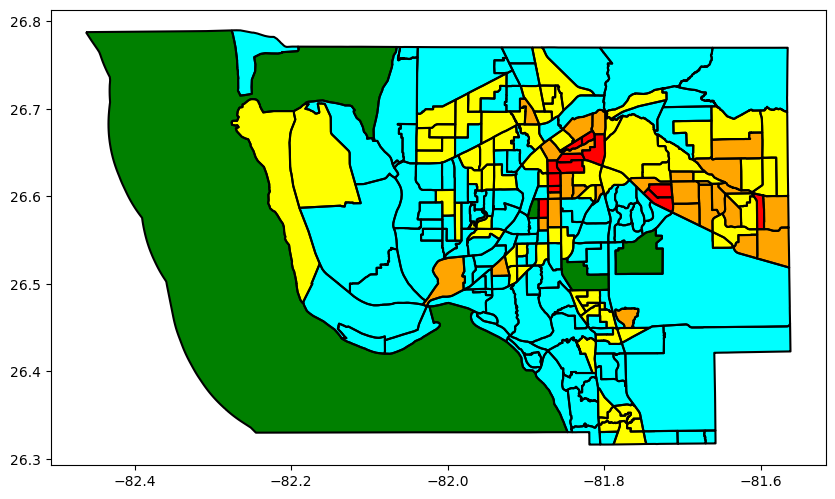

In [84]:
# select only the tracts located in lee county. map social vulnerability to different tracts

def zone_to_color(value):
    GEOID = "1400000US" + value
    index = np.where(sv_df['GEO_ID'] == GEOID)[0]
    sv_zone = sv_df.loc[index[0]]["zone"][-2:-3:-1]
    if sv_zone == "1": return "green"
    elif sv_zone == "2": return "cyan"
    elif sv_zone == "3": return "yellow"
    elif sv_zone == "4": return "orange"
    else: return "red"

colors = df['TRACTID'].apply(zone_to_color)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df.boundary.plot(ax=ax, edgecolor='black')
df.plot(ax=ax, color=colors)

plt.show()

In [93]:
# load openfema owners data
owner_data = gpd.read_file(r"../data/HousingAssistanceOwners.csv")

# load zipcode shape files
df = gpd.read_file(r"C:\Users\zacat\Downloads\cb_2018_us_zcta510_500k\cb_2018_us_zcta510_500k.shp")
df = df.to_crs("EPSG:4326")

,disasterNumber,state,county,city,zipCode,validRegistrations,averageFemaInspectedDamage,totalInspected,totalDamage,noFemaInspectedDamage,...,totalApprovedIhpAmount,repairReplaceAmount,rentalAmount,otherNeedsAmount,approvedBetween1And10000,approvedBetween10001And25000,approvedBetween25001AndMax,totalMaxGrants,id,geometry
0,1439,TX,Aransas (County),ARANSAS PASS,78335,4,1345.01,3,5380.02,0,...,5915.91,3573.02,970,1372.89,3,0,0,0,24148449-87c6-4f58-8d14-e469c3f0581a,None
1,1439,TX,Aransas (County),ARANSAS PASS,78336,68,3082.82,63,209632.06,4,...,180717.57,131097.36,23946,25674.21,27,26,1,0,03688be7-62df-43e2-b2b3-0eefc8516644,None
2,1439,TX,Aransas (County),FULTON,78358,20,4722.34,18,94446.72,0,...,94240.88,58754.7,6784,28702.18,3,11,3,0,fa08ef35-8563-49bb-bb74-2fe8d64f4d77,None
3,1439,TX,Aransas (County),FULTON,78381,1,2578.3,1,2578.3,0,...,3304.3,1407.96,726,1170.34,1,0,0,0,fc5e65b1-522d-48e7-b3e2-69eb560caf00,None
4,1439,TX,Aransas (County),ROCKPORT,78331,1,0,0,0,0,...,0,0,0,0,0,0,0,0,37a8634d-3c69-44a3-8414-c281e22ff561,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140244,9808,PA,Berks (County),WYOMISSING,19610,1,0,0,0,0,...,0,0,0,0,0,0,0,0,5cb8e7b0-315e-4a5a-a8ec-fd1d1df72c07,None
140245,9808,PA,Chester (County),WEST CHESTER,19382,2,0,0,0,0,...,0,0,0,0,0,0,0,0,299382e5-6008-4b90-a985-e680b25c44a1,None
140246,9808,PA,Lehigh (County),BREINIGSVILLE,18031,1,0,0,0,0,...,0,0,0,0,0,0,0,0,676a1813-5031-412c-8eda-43d50e9a2a46,None
140247,9808,PA,Schuylkill (County),NEW PHILADELPHIA,17959,1,0,0,0,0,...,0,0,0,0,0,0,0,0,e26e5023-abc3-458b-a753-9db9950ff11b,None


11176.24
3053.84
3926.12
27749.25
3402.38
4078.99
2228.4


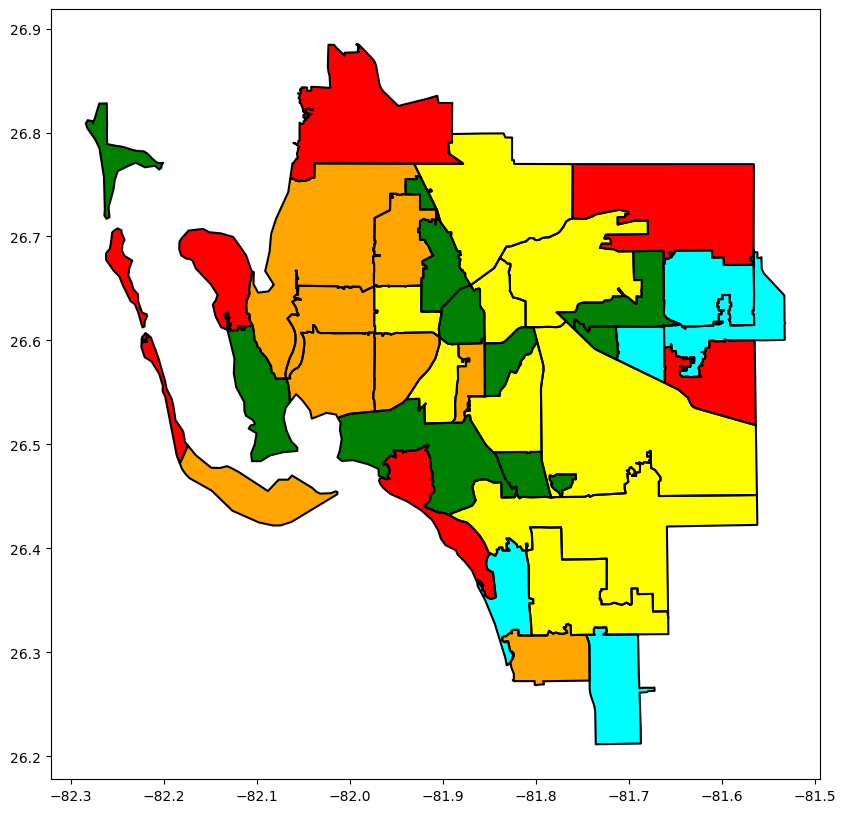

In [98]:


# select only the zip codes located in lee county

lee_zip_codes = [
    33901, 33903, 33904, 33905, 33907, 33908, 33909, 33912, 33913, 33914, 33916, 33917, 33919, 
    33920, 33922, 33928, 33931, 33936, 33955, 33956, 33957, 33966, 33967, 33971, 33972, 33973, 
    33974, 33976, 33990, 33991, 33993, 34110, 34119, 34134, 34135, 33902, 33906, 33910, 33915, 
    33918, 33921, 33924, 33929, 33932, 33945, 33970, 33994, 34133, 34136, 33965
]

lee_zip_codes = [str(val) for val in lee_zip_codes]
df = df[df['ZCTA5CE10'].isin(lee_zip_codes)]

def zone_to_color(value):
    index = np.where(owner_data['zipCode'] == value)[0]
    averageFemaInspectedDamage = owner_data.loc[index[0]]["averageFemaInspectedDamage"]
    if float(averageFemaInspectedDamage) < 200: return "green"
    elif float(averageFemaInspectedDamage) < 500: return "cyan"
    elif float(averageFemaInspectedDamage) < 1000: return "yellow"
    elif float(averageFemaInspectedDamage) < 2000: return "orange"
    else: return "red"

# colors = df['TRACTID'].apply(zone_to_color)
colors = df['ZCTA5CE10'].apply(zone_to_color)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df.boundary.plot(ax=ax, edgecolor='black')
df.plot(ax=ax, color=colors)

plt.show()